# **Dataset and Pre-Processing**

In [ ]:
import json

with open('/content/drive/MyDrive/wikiqa_coursework_dataset/coursework_dataset/train.json') as train_file:
  train_contents = json.load(train_file)

with open('/content/drive/MyDrive/wikiqa_coursework_dataset/coursework_dataset/test.json') as test_file:
  test_contents = json.load(test_file)

with open('/content/drive/MyDrive/wikiqa_coursework_dataset/coursework_dataset/val.json') as val_file:
  val_contents = json.load(val_file)

print(len(train_contents))
print(len(test_contents))
print(len(val_contents))

741
202
103


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#What train looks like
train_contents[0]

{'question': 'how are glacier caves formed?',
 'options': ['The ice facade is approximately 60 m high',
  'A partly submerged glacier cave on Perito Moreno Glacier .',
  'Ice formations in the Titlis glacier cave',
  'A glacier cave is a cave formed within the ice of a glacier .'],
 'correct_index': 3}

### **(1.1) How many questions and options are there in each split? [1 mark]**


In [ ]:
def que_opt_split(dataset):
  print(f"Number of questions: {len(dataset)}")
  options=sum(len(i['options'])for i in dataset)
  print(f"Number of options: {options}")

print("For training dataset")
que_opt_split(train_contents)
print('\n')
print("For testing dataset")
que_opt_split(test_contents)
print('\n')
print("For validation dataset")
que_opt_split(val_contents)

For training dataset
Number of questions: 741
Number of options: 2964


For testing dataset
Number of questions: 202
Number of options: 808


For validation dataset
Number of questions: 103
Number of options: 412


### **(1.2) What is the average number of tokens per question in the training set? [1 mark]**

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

def text_pipeline_spacy_special(text):
  tokens = []
  doc = nlp(text)
  for t in doc:
    if not t.is_punct and not t.is_space: # what we removed: "not t.is_stop and"
      tokens.append(t.text.lower()) # what we changed: t.text instead of t.lemma_
  return tokens

count=[]

for t in train_contents:
  token=text_pipeline_spacy_special(t['question'])#
  count.append(len(token))

avg_tokens= sum(count)/len(count)

print(f"Average number of tokens per question in the training set: {round(avg_tokens,3)}")

Average number of tokens per question in the training set: 6.273


### **(1.3) What is the average number of tokens per choice in the training set? [1 mark]**

In [ ]:
count=[]

for t in train_contents:
  options=t['options']
  for option in options:
    token=text_pipeline_spacy_special(option)
    count.append(len(token))

avg_tokens= sum(count)/len(count)

print(f"Average number of tokens per choice in the training set: {round(avg_tokens,3)}")

Average number of tokens per choice in the training set: 22.338


### **(1.4) What is the average number of tokens per correct choice in the training set? [1 mark]**


In [ ]:
count=[]

for t in train_contents:
  correct_choices=t['correct_index']
  option=t['options'][correct_choices]
  token=text_pipeline_spacy_special(option)
  count.append(len(token))


avg_tokens= sum(count)/len(count)

print(f"Average number of tokens per correct choice in the training set: {round(avg_tokens,3)}")

Average number of tokens per correct choice in the training set: 26.032


### **(1.5) Perform any additional exploration of the data that you feel would be helpful for this multiple-choice question-answering task. Briefly describe what you found. [4 marks]**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the list of dictionaries to a DataFrame
train_data = pd.DataFrame(train_contents)

# Tokenization and data preparation (you need to adjust this based on your actual tokenizer)
train_data['tokenized_questions'] = train_data['question'].apply(lambda q: q.split())  # Simple split, replace with your tokenizer
train_data['tokenized_options'] = train_data['options'].apply(lambda opts: [opt.split() for opt in opts])  # Tokenizing each option

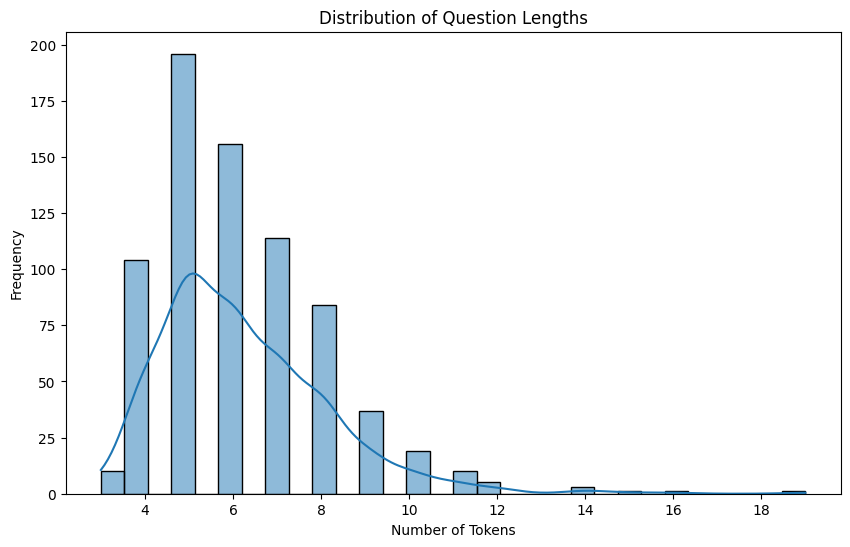

In [ ]:
data=train_data
# Distribution of question lengths
data['question_length'] = data['tokenized_questions'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data['question_length'], bins=30, kde=True)
plt.title('Distribution of Question Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()


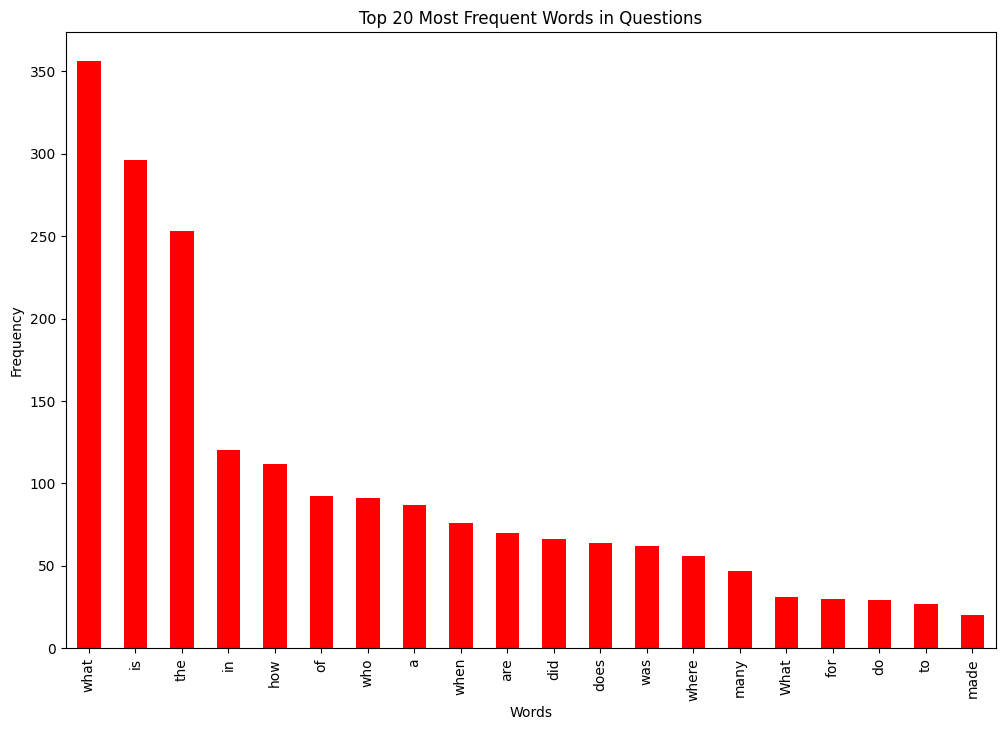

In [ ]:
# Frequency of words in the questions
all_words = [word for tokens in data['tokenized_questions'] for word in tokens]
word_freq = pd.Series(all_words).value_counts().head(20)
plt.figure(figsize=(12, 8))
word_freq.plot(kind='bar', color='red')
plt.title('Top 20 Most Frequent Words in Questions')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns


def get_top_ngrams(corpus, n=None, ngrams=2):
    vec = CountVectorizer(ngram_range=(ngrams, ngrams), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return pd.DataFrame(words_freq[:n], columns=['ngram', 'count'])

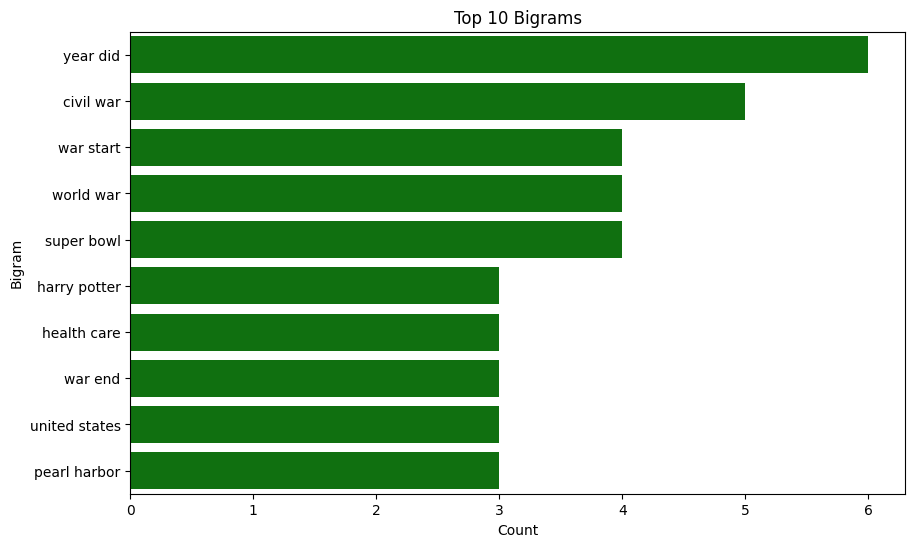

In [ ]:
# Generate top 10 bigrams
top_bigrams = get_top_ngrams(train_data['question'], n=10, ngrams=2)

# Plotting the top bigrams
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='ngram', data=top_bigrams,color='green')
plt.title('Top 10 Bigrams')
plt.xlabel('Count')
plt.ylabel('Bigram')

plt.show()


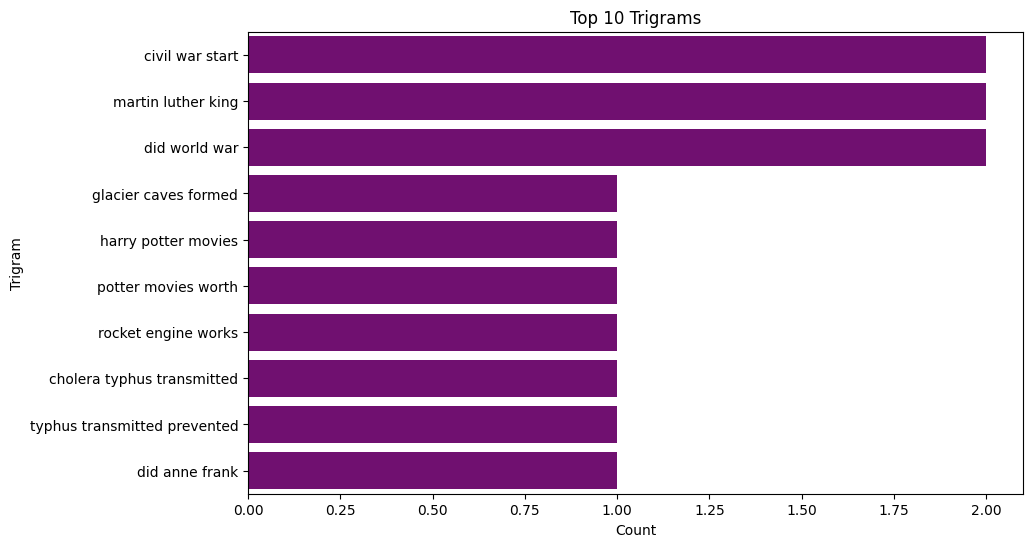

In [ ]:
# Generate top 10 trigrams
top_trigrams = get_top_ngrams(train_data['question'], n=10, ngrams=3)

# Plotting the top trigrams
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='ngram', data=top_trigrams, color= 'purple')
plt.title('Top 10 Trigrams')
plt.xlabel('Count')
plt.ylabel('Trigram')

plt.show()

# **Q2 - Set Similarity Measures [10 marks]**


### **(2.1) Report the performance of each similarity measure (overlap coefficient, Sorensen-Dice & Jaccard) on the training and validation sets by measuring accuracy. [6 marks]**

In [ ]:
def overlap_coefficient(tokens_X,tokens_Y):
  tokens_X = set(tokens_X)
  tokens_Y = set(tokens_Y)
  intersection = tokens_X.intersection(tokens_Y)
  return len(intersection) / min(len(tokens_X),len(tokens_Y))

def sorenson_dice(tokens_X,tokens_Y):
  tokens_X = set(tokens_X)
  tokens_Y = set(tokens_Y)
  intersection = tokens_X.intersection(tokens_Y)
  return 2 * len(intersection) / (len(tokens_X) + len(tokens_Y))

def jaccard_similarity(tokens_X,tokens_Y):
  tokens_X = set(tokens_X)
  tokens_Y = set(tokens_Y)
  intersection = tokens_X.intersection(tokens_Y)
  union = tokens_X.union(tokens_Y)
  return len(intersection) / len(union)

def compute_accuracy(predictions, labels):
    correct = sum(pred == label for pred, label in zip(predictions, labels))
    total = len(labels)
    return correct / total

def contents(data):
  for similarity_measure in [overlap_coefficient,sorenson_dice,jaccard_similarity]:
    max_coeffs=[]
    correct_all_coeff=[]
    for t in data:
      question_token=text_pipeline_spacy_special(t['question'])#
      options=t['options']
      max_coeff=0
      all_coeff=[]
      for option in options:
        option_token=text_pipeline_spacy_special(option)
        curr_coeff=similarity_measure(question_token, option_token)
        all_coeff.append(curr_coeff)
        max_coeff = max(max_coeff, curr_coeff)
      max_coeffs.append(max_coeff)
      correct_choices=t['correct_index']
      correct_choice=t['options'][correct_choices]
      correct_choices_option=text_pipeline_spacy_special(correct_choice)
      correct_curr_coeff=similarity_measure(question_token, correct_choices_option)
      correct_all_coeff.append(correct_curr_coeff)

    accuracy = compute_accuracy(max_coeffs, correct_all_coeff)

    if data==train_contents:
      d="training"
    else:
      d="validation"
    print(f"similarity measure {similarity_measure.__name__} {d} accuracy :{round(accuracy,3)}")

contents(train_contents)
contents(val_contents)

similarity measure overlap_coefficient training accuracy :0.664
similarity measure sorenson_dice training accuracy :0.443
similarity measure jaccard_similarity training accuracy :0.443
similarity measure overlap_coefficient validation accuracy :0.621
similarity measure sorenson_dice validation accuracy :0.359
similarity measure jaccard_similarity validation accuracy :0.359


### **(2.2) For each similarity measure, how many times was the score of the most similar answer tied with another answer? When there was a tied score among the top answers, how did you choose which to select? Why? [4 marks]**

In [ ]:
import random

def contents_with_random_tie_break(data):
    for similarity_measure in [overlap_coefficient, sorenson_dice, jaccard_similarity]:
        ties_count = 0
        for t in data:
            question_token = text_pipeline_spacy_special(t['question'])
            options = t['options']
            max_coeff = 0
            all_coeff = []
            for option in options:
                option_token = text_pipeline_spacy_special(option)
                curr_coeff = similarity_measure(question_token, option_token)
                all_coeff.append(curr_coeff)
                max_coeff = max(max_coeff, curr_coeff)
            max_coeffs_count = all_coeff.count(max_coeff)
            if max_coeffs_count > 1:
                ties_count += 1
                # Randomly select one of the tied scores as the selected answer
                max_indices = [i for i, coeff in enumerate(all_coeff) if coeff == max_coeff]
                selected_index = random.choice(max_indices)
            else:
                selected_index = all_coeff.index(max_coeff)

            correct_choices = t['correct_index']
            correct_choice = t['options'][correct_choices]
            correct_choices_option = text_pipeline_spacy_special(correct_choice)
            correct_curr_coeff = similarity_measure(question_token, correct_choices_option)

        if data == train_contents:
            d = "training"
        else:
            d = "validation"
        print(f"similarity measure {similarity_measure.__name__} {d} ties count: {ties_count}")

contents_with_random_tie_break(train_contents)
contents_with_random_tie_break(val_contents)


similarity measure overlap_coefficient training ties count: 246
similarity measure sorenson_dice training ties count: 20
similarity measure jaccard_similarity training ties count: 20
similarity measure overlap_coefficient validation ties count: 29
similarity measure sorenson_dice validation ties count: 4
similarity measure jaccard_similarity validation ties count: 4


In [ ]:
import random

def contents_with_accuracy(data):
    for similarity_measure in [overlap_coefficient, sorenson_dice, jaccard_similarity]:
        predictions = []
        labels = []
        for t in data:
            question_token = text_pipeline_spacy_special(t['question'])
            options = t['options']
            max_coeff = 0
            all_coeff = []
            for option in options:
                option_token = text_pipeline_spacy_special(option)
                curr_coeff = similarity_measure(question_token, option_token)
                all_coeff.append(curr_coeff)
                max_coeff = max(max_coeff, curr_coeff)
            max_coeffs_count = all_coeff.count(max_coeff)
            if max_coeffs_count > 1:
                # Randomly select one of the tied scores as the selected answer
                max_indices = [i for i, coeff in enumerate(all_coeff) if coeff == max_coeff]
                selected_index = random.choice(max_indices)
            else:
                selected_index = all_coeff.index(max_coeff)

            correct_choices = t['correct_index']
            predictions.append(selected_index)
            labels.append(correct_choices)

        accuracy = compute_accuracy(predictions, labels)

        if data == train_contents:
            d = "training"
        else:
            d = "validation"
        print(f"similarity measure {similarity_measure.__name__} {d} accuracy :{round(accuracy,3)}")

contents_with_accuracy(train_contents)
contents_with_accuracy(val_contents)


similarity measure overlap_coefficient training accuracy :0.524
similarity measure sorenson_dice training accuracy :0.429
similarity measure jaccard_similarity training accuracy :0.428
similarity measure overlap_coefficient validation accuracy :0.456
similarity measure sorenson_dice validation accuracy :0.359
similarity measure jaccard_similarity validation accuracy :0.359


# **Q3 - Cosine similarity of TF vectors [12 marks]**

### **(3.1) Report the performance of the training and validation sets by measuring accuracy. Discuss how they compare with the set similarity measures from Q2. [6 marks]**


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Tokenization function
def text_pipeline_spacy_special(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_punct and not t.is_space:
            tokens.append(t.text.lower())
    return tokens

# Function to generate TF vectors
def generate_tf_vectors(data):
    questions = [t['question'] for t in data]
    answers = [option for t in data for option in t['options']]

    vectorizer = CountVectorizer(tokenizer=text_pipeline_spacy_special)
    question_vectors = vectorizer.fit_transform(questions)
    answer_vectors = vectorizer.transform(answers)

    return question_vectors, answer_vectors

# Function to compute accuracy based on cosine similarity
def compute_accuracy_cosine(question_vectors, answer_vectors, data):
    correct = 0
    total = len(data)

    for i, t in enumerate(data):
        question_vector = question_vectors[i]
        options = t['options']
        correct_choice_index = t['correct_index']
        correct_choice_vector = answer_vectors[4*i + correct_choice_index]

        max_similarity = -1
        predicted_index = -1
        for j, option in enumerate(options):
            option_vector = answer_vectors[4*i + j]
            similarity = cosine_similarity(question_vector, option_vector)
            if similarity > max_similarity:
                max_similarity = similarity
                predicted_index = j

        if predicted_index == correct_choice_index:
            correct += 1

    accuracy = correct / total
    return accuracy

# Generate TF vectors for training and validation sets
train_question_vectors, train_answer_vectors = generate_tf_vectors(train_contents)
val_question_vectors, val_answer_vectors = generate_tf_vectors(val_contents)

# Compute accuracy for training and validation sets
train_accuracy = compute_accuracy_cosine(train_question_vectors, train_answer_vectors, train_contents)
val_accuracy = compute_accuracy_cosine(val_question_vectors, val_answer_vectors, val_contents)

print(f"Training set accuracy based on cosine similarity: {round(train_accuracy,4)}")
print(f"Validation set accuracy based on cosine similarity: {round(val_accuracy,4)}")


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Training set accuracy based on cosine similarity: 0.4399
Validation set accuracy based on cosine similarity: 0.4466


### **(3.2) Propose, motivate, and evaluate one modification to this process to improve this method. Report the performance on the training and development sets and compare them with the unmodified version. [6 marks]**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def generate_tfidf_vectors(data):
    questions = [t['question'] for t in data]
    answers = [option for t in data for option in t['options']]

    vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy_special)
    question_vectors = vectorizer.fit_transform(questions)
    answer_vectors = vectorizer.transform(answers)

    return question_vectors, answer_vectors

train_question_vectors_tfidf, train_answer_vectors_tfidf = generate_tfidf_vectors(train_contents)
val_question_vectors_tfidf, val_answer_vectors_tfidf = generate_tfidf_vectors(val_contents)

train_accuracy_tfidf = compute_accuracy_cosine(train_question_vectors_tfidf, train_answer_vectors_tfidf, train_contents)
val_accuracy_tfidf = compute_accuracy_cosine(val_question_vectors_tfidf, val_answer_vectors_tfidf, val_contents)

print(f"Training set accuracy based on cosine similarity with TF-IDF: {round(train_accuracy_tfidf,4)}")
print(f"Validation set accuracy based on cosine similarity with TF-IDF: {round(val_accuracy_tfidf,4)}")


Training set accuracy based on cosine similarity with TF-IDF: 0.4359
Validation set accuracy based on cosine similarity with TF-IDF: 0.4466


# **Q4 - Cosine similarity of vectors from bert-base-uncased [12 marks]**

### **(4.1) Report the performance of the training and validation sets by measuring accuracy. [8 marks]**

In [ ]:
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


# Function to generate BERT context vectors
def generate_bert_vectors(data):
    question_vectors = []
    answer_vectors = []

    for entry in data:
        question = entry['question']
        options = entry['options']

        # Tokenize question
        question_tokens = tokenizer.encode(question, add_special_tokens=True, return_tensors='pt')

        # Tokenize all options together
        options_tokens = tokenizer(options, add_special_tokens=True, return_tensors='pt', padding=True, truncation=True)

        # Generate BERT embeddings
        with torch.no_grad():
            question_output = model(question_tokens)[0][:, 0, :]  # Extract CLS token representations
            answer_output = model(**options_tokens)[0][:, 0, :]   # Extract CLS token representations

        # Ensure question_output and answer_output are tensors
        if not isinstance(question_output, torch.Tensor) or not isinstance(answer_output, torch.Tensor):
            raise ValueError("Expected question_output and answer_output to be tensors.")

        # Convert tensors to numpy arrays
        question_cls_np = question_output.numpy()
        answer_cls_np = answer_output.numpy()

        question_vectors.append(question_cls_np)
        answer_vectors.append(answer_cls_np)

    return question_vectors, answer_vectors



# Function to compute accuracy based on cosine similarity
def compute_accuracy_cosine_bert(question_vectors, answer_vectors, data):
    correct = 0

    for question_vector, answer_vector_list, entry in zip(question_vectors, answer_vectors, data):
        # Calculate cosine similarity for each answer
        max_similarity = -1
        predicted_answer = None

        for answer_vector, option in zip(answer_vector_list, entry['options']):
            similarity = cosine_similarity(question_vector, answer_vector.reshape(1, -1))[0][0]

            if similarity > max_similarity:
                max_similarity = similarity
                predicted_answer = option

        # Check if predicted answer is correct
        if predicted_answer == entry['options'][entry['correct_index']]:
            correct += 1

    accuracy = correct / len(data)
    return accuracy

# Generate BERT context vectors for training and validation sets
train_question_vectors_bert, train_answer_vectors_bert = generate_bert_vectors(train_contents)
val_question_vectors_bert, val_answer_vectors_bert = generate_bert_vectors(val_contents)

# Calculate accuracy for training and validation sets
train_accuracy_bert = compute_accuracy_cosine_bert(train_question_vectors_bert, train_answer_vectors_bert, train_contents)
val_accuracy_bert = compute_accuracy_cosine_bert(val_question_vectors_bert, val_answer_vectors_bert, val_contents)

# Report performance
print(f"Training set accuracy based on cosine similarity with BERT vectors: {round(train_accuracy_bert,3)}")
print(f"Validation set accuracy based on cosine similarity with BERT vectors: {round(val_accuracy_bert,3)}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Training set accuracy based on cosine similarity with BERT vectors: 0.143
Validation set accuracy based on cosine similarity with BERT vectors: 0.204


# **Q5 - Fine-tuning a transformer model [18 marks]**

###**(5.1) Report the accuracy, precision, recall and F1 score of the predictions on the question-option pairs representation of the training and validation sets [10 marks]**

In [ ]:
import pandas as pd
from transformers import BertTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Assuming 'data' is your dataset loaded into Python
def transform_data(data):
    transformed_data = []
    for item in data:
        question = item['question']
        for i, option in enumerate(item['options']):
            text = question + " [SEP] " + option
            label = 1 if i == item['correct_index'] else 0
            transformed_data.append({'text': text, 'label': label})
    return pd.DataFrame(transformed_data)

train_df = transform_data(train_contents)
val_df = transform_data(val_contents)


In [ ]:
!pip install datasets
!pip install accelerate -U
!pip install transformers --upgrade
!pip install transformers[torch]

In [ ]:
from transformers import set_seed, AutoModelForSequenceClassification
import pandas as pd
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

set_seed(42)

model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

learning_rate = 1e-5
batch_size = 8
epochs = 4
weight_decay = 0

def create_question_option_pairs(data):
    question_option_pairs = []
    for item in data:
        question = item["question"]
        options = item["options"]
        correct_index = item["correct_index"]
        for i, option in enumerate(options):
            label = 1 if i == correct_index else 0
            pair = {"input_ids": f"{question}[SEP]{option}", "labels": label}
            pair["input_ids"] = tokenizer.encode(pair["input_ids"],truncation=True, padding='max_length', max_length=64)
            question_option_pairs.append(pair)
    return question_option_pairs

train_df = create_question_option_pairs(train_contents)
val_df = create_question_option_pairs(val_contents)

train_df = pd.DataFrame(train_df)
val_df = pd.DataFrame(val_df)

print(train_df.shape)
print(train_df["labels"][0])

#!pip install accelerate -U
#!pip install transformers --upgrade

from datasets import Dataset
train_dataset = Dataset.from_dict(train_df)
val_dataset = Dataset.from_dict(val_df)
train_dataset

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="My_model",
    evaluation_strategy="epoch", # How often we want to evaluate the model
    learning_rate=learning_rate, # Hyperparameter
    per_device_train_batch_size=batch_size, # Hyperparameter
    per_device_eval_batch_size=batch_size, # Hyperparameter
    num_train_epochs=epochs, # Hyperparameter
    weight_decay=weight_decay, # Hyperparameter
)

trainer = Trainer(
    model=model, # The model you want to train
    args=training_args, # The various training arguments set up above
    train_dataset=train_dataset, # The data to use to update the weights
    eval_dataset=train_dataset, # The data to use for evaluation
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(2964, 2)
0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch,Training Loss,Validation Loss
1,No log,0.487634
2,0.535400,0.425741
3,0.456200,0.365266
4,0.456200,0.339467


TrainOutput(global_step=1484, training_loss=0.46047931475780723, metrics={'train_runtime': 238.054, 'train_samples_per_second': 49.804, 'train_steps_per_second': 6.234, 'total_flos': 389930584043520.0, 'train_loss': 0.46047931475780723, 'epoch': 4.0})

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

train_predictions = np.argmax(trainer.predict(train_dataset).predictions, axis=1)
val_predictions = np.argmax(trainer.predict(val_dataset).predictions, axis=1)

train_ground_truth = train_df["labels"]
val_ground_truth = val_df["labels"]

train_accuracy = accuracy_score(train_ground_truth, train_predictions)
train_precision = precision_score(train_ground_truth, train_predictions)
train_recall = recall_score(train_ground_truth, train_predictions)
train_f1_score = f1_score(train_ground_truth, train_predictions)

val_accuracy = accuracy_score(val_ground_truth, val_predictions)
val_precision = precision_score(val_ground_truth, val_predictions)
val_recall = recall_score(val_ground_truth, val_predictions)
val_f1_score = f1_score(val_ground_truth, val_predictions)

print("Training set:")
print(f"Accuracy: {round(train_accuracy,3)}")
print(f"Precision:{round(train_precision,3)}" )
print(f"Recall: {round(train_recall,3)}")
print(f"F1 Score:{round(train_f1_score,3)}")

print("\nValidation set:")
print(f"Accuracy:{round(val_accuracy,3)}" )
print(f"Precision:{round(val_precision,3)}")
print(f"Recall: {round(val_recall,3)}")
print(f"F1 Score:{round(val_f1_score,3)}")

Training set:
Accuracy: 0.855
Precision:0.693
Recall: 0.75
F1 Score:0.721

Validation set:
Accuracy:0.791
Precision:0.588
Recall: 0.553
F1 Score:0.57


###**(5.2) Report the accuracy for this method for selecting the correct answer on the training and validation sets of this model. [6 marks]**

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

train_predictions = np.argmax(trainer.predict(train_dataset).predictions, axis=1)
val_predictions = np.argmax(trainer.predict(val_dataset).predictions, axis=1)

# Ground truth labels
train_ground_truth = train_df["labels"]
val_ground_truth = val_df["labels"]

# Calculate accuracy
train_accuracy = accuracy_score(train_ground_truth, train_predictions)
val_accuracy = accuracy_score(val_ground_truth, val_predictions)

print(f"Training set accuracy:{round(train_accuracy,3)}")
print(f"Validation set accuracy:{round(val_accuracy,3)}")


Training set accuracy:0.855
Validation set accuracy:0.791


#**Q6 - Test set performance [4 marks]**

###**(6.1) Report the accuracy using your best method on the test set. Use the performance on the validation set to select the best method. [2 marks]**

In [ ]:
# Assuming test_contents is available and structured like train_contents
test_df = create_question_option_pairs(test_contents)
test_df = pd.DataFrame(test_df)

# Convert the test DataFrame to a Hugging Face Dataset
from datasets import Dataset
test_dataset = Dataset.from_dict(test_df)

# Make predictions on the test set
test_predictions = trainer.predict(test_dataset).predictions
test_predictions = np.argmax(test_predictions, axis=1)

# Extract the ground truth labels
test_ground_truth = test_df["labels"].values

# Calculate the accuracy on the test set
from sklearn.metrics import accuracy_score
test_accuracy = accuracy_score(test_ground_truth, test_predictions)

print(f"Test set accuracy:{round(test_accuracy,3)}")


Test set accuracy:0.776
